In [94]:
import boto3
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import urllib


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [79]:
def scan_all(table):
    response = table.scan()
    data = response['Items']
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        data.extend(response['Items'])
    return data

In [80]:
dynamodb = boto3.resource('dynamodb')
idealista_scrap_table = dynamodb.Table('scrapped_ads')
imovirtual_scrap_table = dynamodb.Table('imovirtual_scrap')
idealista_scrap_rows = scan_all(idealista_scrap_table) #idealista_scrap_table.scan()
imovirtual_scrap_rows = scan_all(imovirtual_scrap_table) #imovirtual_scrap_table.scan()

In [84]:
df_idealista = pd.DataFrame(idealista_scrap_rows)
df_imovirtual = pd.DataFrame(imovirtual_scrap_rows)

print('Idealista: {}\nImovirtual: {}'.format(len(df_idealista), len(df_imovirtual)))

Idealista: 853
Imovirtual: 348


In [222]:

def calc_price_by_area(df):
    df['created_datetime'] = pd.to_datetime(df['created'], format='%d-%m-%Y %H:%M:%S')
    df['size'] = pd.to_numeric(df['size'])
    df['price'] = pd.to_numeric(df['price'])
    df['price_area'] = df.apply(lambda x: x['price'] / x['size'], axis=1)
    return df
    
df_idealista = calc_price_by_area(df_idealista)
df_imovirtual = calc_price_by_area(df_imovirtual)
mean_day_idealista = df_idealista.groupby('created_datetime').mean()
mean_day_imovirtual = df_imovirtual.groupby('created_datetime').mean()

df_idealista['day_name'] = df_idealista['created_datetime'].dt.dayofweek
df_imovirtual['day_name'] = df_imovirtual['created_datetime'].dt.dayofweek
day_name_idealista = df_idealista.groupby('day_name')
day_name_imovirtual = df_imovirtual.groupby('day_name')

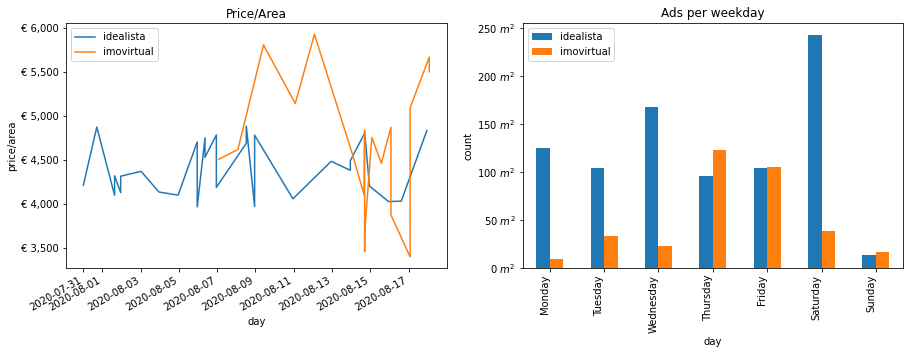

In [237]:
import numpy as np
def remove_outliers(df):
    return df[df.between(df.quantile(.15), df.quantile(.85))]

fig,axs = plt.subplots(1, 2, figsize = (15, 5))

ax = axs[0]
ax.plot(
    mean_day_idealista_clean.index,
    remove_outliers(mean_day_idealista['price_area']),
    label='idealista'
)
ax.plot(
    mean_day_imovirtual_clean.index,
    remove_outliers(mean_day_imovirtual['price_area']),
    label='imovirtual'
)


ax.set_xlabel("day")
ax.set_ylabel("price/area")
ax.legend(loc='best')
ax.set_title("Price/Area")

fmt = '€ {x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.gcf().autofmt_xdate()


idealista_ads_per_day = day_name_idealista.count()['size']
imovirtual_ads_per_day = day_name_imovirtual.count()['size']
bar_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df = pd.DataFrame(np.c_[idealista_ads_per_day,imovirtual_ads_per_day], index=bar_names, columns=['idealista','imovirtual'])
df.plot.bar(ax=axs[1])

fmt = '€ {x:,.0f}'
tick = mtick.StrMethodFormatter('{x:,.0f} $m^2$')
axs[1].yaxis.set_major_formatter(tick) 
axs[1].set_xlabel("day")
axs[1].set_ylabel("count")
axs[1].legend(loc='best')
axs[1].set_title("Ads per weekday");
